## Exam admission assignment - Navigation
This assignment is mandatory for all students of mobile robots to get the admission to participate in the exam.
The assignment will treat a navigation task, combining already familiar local and global planner.
On the presentation date you have to present the 

1. Initialize python node

In [1]:
# This is the equivalent of matlab_node = ros2node(...)
import rclpy
from rclpy.node import Node

rclpy.init() # initialize node
Python_node = Node("ROS2_nav") # Create the node object

2) Initiate a velocity publisher and a subscriber for the current pose ("/odom") 

In [2]:
from rclpy.node import Node
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Twist
from scipy.spatial.transform import Rotation as R

current_pose = None
latest_odom_msg = None
def odom_callback(msg):
    global current_pose, latest_odom_msg
    
    # Store the entire message for later use (e.g., getting velocity)
    latest_odom_msg = msg
    x = msg.pose.pose.position.x
    y = msg.pose.pose.position.y
    q = msg.pose.pose.orientation
    r = R.from_quat([q.x, q.y, q.z, q.w])
    theta, _, _ = r.as_euler('zyx')
    current_pose = [x, y, theta]

    

velPub = Python_node.create_publisher(Twist, '/cmd_vel', 10)
odomSub = Python_node.create_subscription(Odometry,'/odom',odom_callback,10)
Python_node.get_logger().info('Velocity & Odometry node has been started.')

[INFO] [1751567590.929747684] [ROS2_nav]: Velocity & Odometry node has been started.


True

3) Initiate a goal subscriber to the "/goal_pose" topic from RVIZ with a subscriber callback that fills the values of the goal handle. 

In [3]:
class PoseHandle:
    """
    POSEHANDLE Summary of this class goes here
    Detailed explanation goes here
    """
    def __init__(self):
        self.x = 0
        self.y = 0
        self.theta = 0

In [4]:
from geometry_msgs.msg import PoseStamped
goalHandle = PoseHandle()
goal_recieved = False
def goalcallback(msg):
    global goalHandle, goal_recieved
    goalHandle.x = msg.pose.position.x
    goalHandle.y = msg.pose.position.y
    q = msg.pose.orientation
    r = R.from_quat([q.x, q.y, q.z, q.w]) 
    theta, _, _ = r.as_euler('zyx')
    goalHandle.theta = theta
    goal_recieved = True

goalSub = Python_node.create_subscription(PoseStamped,'/goal_pose',goalcallback,10)


In [5]:
from tf2_ros.buffer import Buffer
from tf2_ros.transform_listener import TransformListener

Python_node.tf_buffer = Buffer()
Python_node.tf_listener = TransformListener(Python_node.tf_buffer, Python_node)


In [6]:

def goal_handle_to_goal_pose(goalHandle):
    pt = PoseStamped()
    pt.header.frame_id = 'map'
    pt.header.stamp = rclpy.time.Time().to_msg()
    
    pt.pose.position.x = goalHandle.x
    pt.pose.position.y = goalHandle.y
    pt.pose.position.z = 0.0

    # Convert theta to quaternion using scipy
    quat = R.from_euler('z', goalHandle.theta).as_quat()  # returns [x, y, z, w]
    pt.pose.orientation.x = quat[0]
    pt.pose.orientation.y = quat[1]
    pt.pose.orientation.z = quat[2]
    pt.pose.orientation.w = quat[3]

    try:
        transformed_pose = Python_node.tf_buffer.transform(pt, 'odom', timeout=rclpy.duration.Duration(seconds=1.0))
    except Exception as e:
        print(f"Transform failed: {e}")
        return None
    return transformed_pose

4) Load the map and display it. Also add the goal pose.

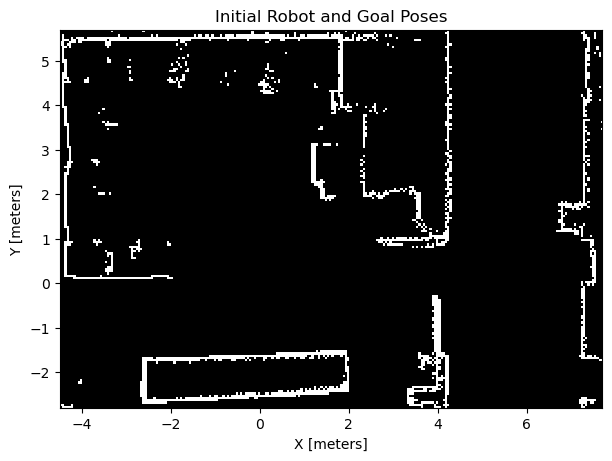

[INFO] [1751567602.054525346] [ROS2_nav]: Waiting... Please publish a goal in RVIZ if you have not.
[INFO] [1751567604.076758555] [ROS2_nav]: Waiting... Please publish a goal in RVIZ if you have not.
[INFO] [1751567606.083051456] [ROS2_nav]: Waiting... Please publish a goal in RVIZ if you have not.
[INFO] [1751567608.096424565] [ROS2_nav]: Waiting... Please publish a goal in RVIZ if you have not.
[INFO] [1751567608.435890781] [ROS2_nav]: Waiting for initial odometry and goal...


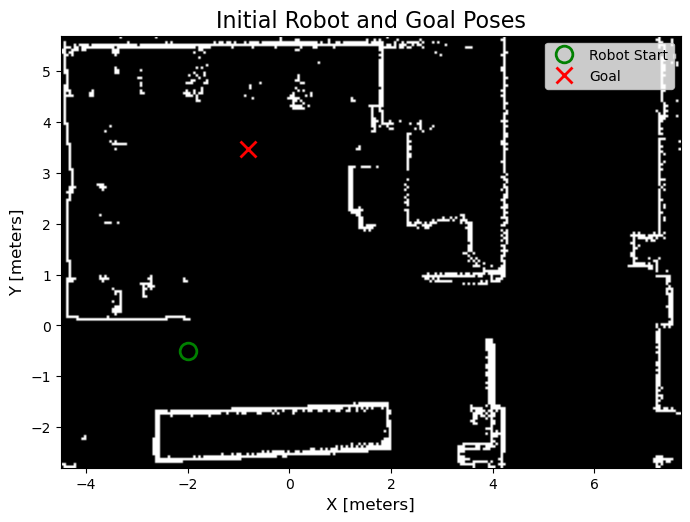

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tf2_geometry_msgs import do_transform_pose_stamped


# Load image in grayscale
map_img = Image.open('/home/deepu718/ROS2/rst_lab_cropped.pgm').convert('L')
map_img = np.array(map_img)

# Convert to binary: obstacles = True
bwimage = map_img < 100

# Rotate 90 degrees clockwise (equivalent to MATLAB's imrotate 90)
bwimage = np.rot90(bwimage, k=1)
bwimage = np.flipud(bwimage)
# Define resolution and origin
res = 0.05
x_origin, y_origin = -4.5, -2.8

# Define extent (same as MATLAB map.GridLocationInWorld)
extent = [x_origin, x_origin + bwimage.shape[1]*res,
          y_origin, y_origin + bwimage.shape[0]*res]

# Plot using imshow
plt.figure(figsize=(7,7))
plt.imshow(bwimage, cmap='gray', origin='lower', extent=extent, interpolation='nearest')
plt.title('Initial Robot and Goal Poses')
plt.xlabel('X [meters]')
plt.ylabel('Y [meters]')
plt.show()
while (current_pose is None or not goal_recieved) and rclpy.ok():
    # Let the user know what's happening
    Python_node.get_logger().info('Waiting... Please publish a goal in RVIZ if you have not.', throttle_duration_sec=2)
    rclpy.spin_once(Python_node, timeout_sec=0.1)
Python_node.get_logger().info('Waiting for initial odometry and goal...')
# opose = current
[robot_x, robot_y, robot_theta] = current_pose

goalPose = goal_handle_to_goal_pose(goalHandle)
goal_x = goalPose.pose.position.x
goal_y = goalPose.pose.position.y

plt.figure(figsize=(8, 8)) # A slightly larger figure can look better
ax = plt.gca() # Get the current axes to plot on

# 3. Plot the map image as the background
# The 'extent' correctly scales and positions the image in the world frame
ax.imshow(bwimage, cmap='gray', origin='lower', extent=extent)

# 4. Plot the robot's starting position
# 'go' = green circle.
# 'fillstyle='none'' makes it hollow.
# 'mew=2' is marker edge width, equivalent to MATLAB's 'LineWidth' for markers.
ax.plot(robot_x, robot_y, 'go', markersize=12, fillstyle='none', mew=2, label='Robot Start')

# 5. Plot the goal position
# 'rx' = red x.
# 'mew=2' makes the 'x' thicker.
ax.plot(goal_x, goal_y, 'rx', markersize=12, mew=2, label='Goal')

# 6. Add labels, title, and legend
ax.set_title('Initial Robot and Goal Poses', fontsize=16)
ax.set_xlabel('X [meters]', fontsize=12)
ax.set_ylabel('Y [meters]', fontsize=12)
ax.legend()

# 7. (Optional but recommended) Ensure the aspect ratio is correct
ax.set_aspect('equal', adjustable='box')

# 8. Show the final, combined plot
plt.show()


Executing RRT with MATLAB-like parameters...
Goal region reached at iteration 47!
Path found!


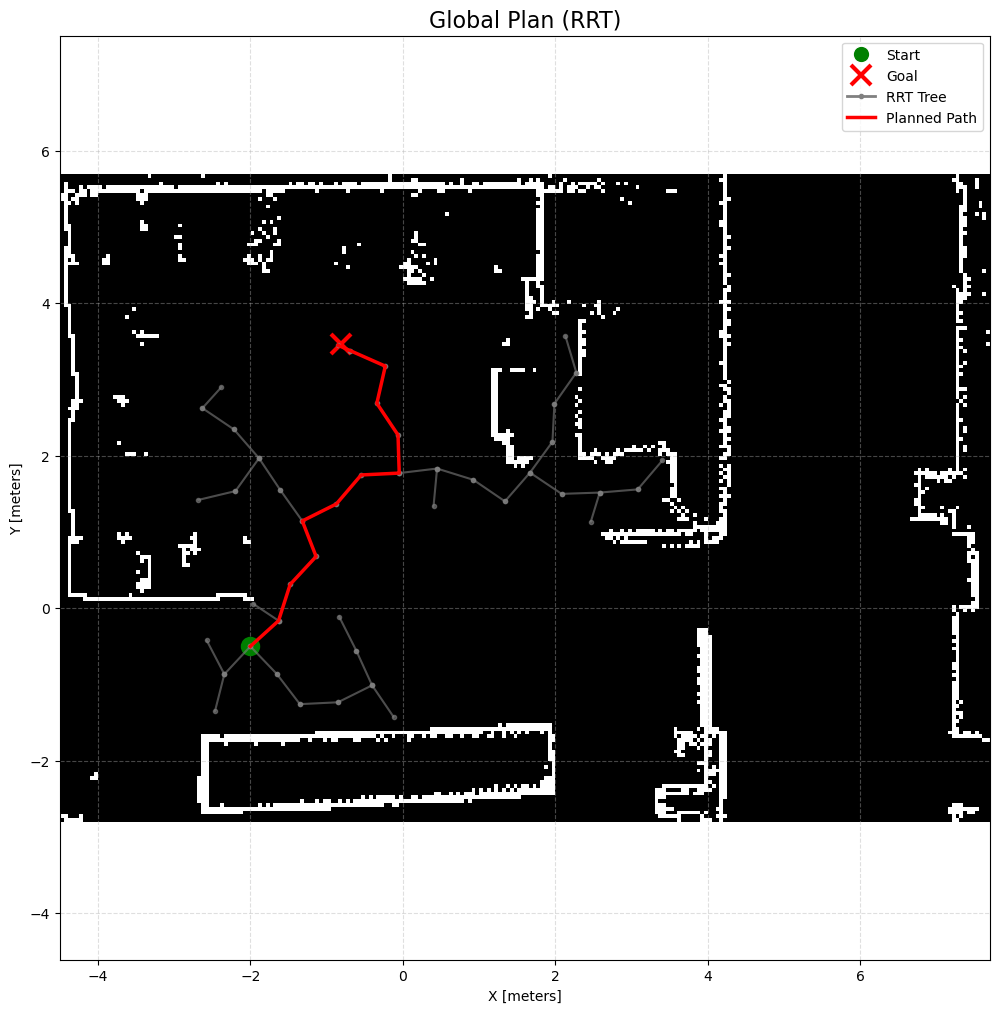

In [8]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt # The main library for all plotting functions
from matplotlib.lines import Line2D
# ==============================================================================
# PART 2: GLOBAL PLANNER IMPLEMENTATIONS
# ==============================================================================

# --- Helper Functions and Classes ---
class Node:
    """Node class for RRT/PRM planners."""
    def __init__(self, x, y):
        self.x, self.y, self.parent, self.cost = x, y, None, 0.0
        self.path_x, self.path_y = [], []

def world_to_map(world_coords, origin, res):
    """Converts world coordinates (meters) to map coordinates (pixels)."""
    return [int((c - o) / res) for c, o in zip(world_coords, origin)]

def map_to_world(map_coords, origin, res):
    """Converts map coordinates (pixels) to world coordinates (meters)."""
    return [c * res + o for c, o in zip(map_coords, origin)]

# ------------------------------------------------------------------------------
# RRT Planner - Tweaked to Mirror MATLAB's High-Quality RRT
# ------------------------------------------------------------------------------
class RRT:
    """RRT Planner tuned for high-quality paths."""
    def __init__(self, obstacle_map, start, goal, expand_dis=15.0,
                 path_resolution=1.0, goal_sample_rate=10, max_iter=500,
                 goal_reached_dist=5.0):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.obstacle_map = obstacle_map
        self.map_height, self.map_width = obstacle_map.shape
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.goal_reached_pixel_dist = goal_reached_dist
        self.node_list = []

    def plan(self):
        """Main planning function."""
        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]
            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.is_collision_free(new_node):
                self.node_list.append(new_node)
                if self.calc_dist_to_goal(new_node.x, new_node.y) <= self.goal_reached_pixel_dist:
                    print(f"Goal region reached at iteration {i}!")
                    final_node = self.steer(new_node, self.end)
                    if self.is_collision_free(final_node):
                        return self.generate_final_path(final_node)
        return None, self.get_tree_for_plotting(), False

    def generate_final_path(self, goal_node):
        """Reconstructs the path from a goal node."""
        path = [[self.end.x, self.end.y]]
        node = goal_node
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])
        path.reverse()
        return path, self.get_tree_for_plotting(), True

    def is_collision_free(self, node):
        """Robust collision checker for a new path segment."""
        if node is None: return False
        for x, y in zip(node.path_x, node.path_y):
            if not (0 <= y < self.map_height and 0 <= x < self.map_width) or self.obstacle_map[int(y), int(x)]:
                return False
        return True

    def steer(self, from_node, to_node, extend_length=float("inf")):
        new_node = Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)
        new_node.path_x = [new_node.x]; new_node.path_y = [new_node.y]
        extend_length = min(d, extend_length)
        n_expand = math.floor(extend_length / self.path_resolution)
        for _ in range(int(n_expand)):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x); new_node.path_y.append(new_node.y)
        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.x, new_node.y = to_node.x, to_node.y
            new_node.path_x.append(to_node.x); new_node.path_y.append(to_node.y)
        new_node.parent = from_node
        return new_node
        
    def get_tree_for_plotting(self):
        return [([n.x, n.parent.x], [n.y, n.parent.y]) for n in self.node_list if n.parent]
    def calc_dist_to_goal(self, x, y): return math.hypot(x - self.end.x, y - self.end.y)
    def get_random_node(self): return Node(self.end.x, self.end.y) if random.randint(0, 100) <= self.goal_sample_rate else Node(random.uniform(0, self.map_width), random.uniform(0, self.map_height))
    @staticmethod
    def get_nearest_node_index(node_list, rnd_node): return min(range(len(node_list)), key=lambda i: (node_list[i].x - rnd_node.x)**2 + (node_list[i].y - rnd_node.y)**2)
    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx, dy = to_node.x - from_node.x, to_node.y - from_node.y
        return math.hypot(dx, dy), math.atan2(dy, dx)

# (Your PRM and Dijkstra code can remain here unchanged if needed)


# ==============================================================================
# PART 3: MAIN PLANNING AND VISUALIZATION LOGIC
# ==============================================================================
# --- Configuration ---
global_planner = "RRT"

# --- MATLAB-equivalent RRT Parameters ---
RRT_MAX_ITER = 20000
RRT_MAX_CONNECTION_DIST_METERS = 0.5
RRT_GOAL_REACHED_DIST_METERS = 0.1
RRT_PATH_RESOLUTION_PIXELS = 1.0

# --- Convert metric parameters to pixel units for the planner ---
RRT_EXPAND_DIS_PIXELS = RRT_MAX_CONNECTION_DIST_METERS / res
RRT_GOAL_REACHED_PIXELS = RRT_GOAL_REACHED_DIST_METERS / res

# --- Prepare Start and Goal Poses ---
start_world = [robot_x, robot_y]
goal_world = [goalPose.pose.position.x, goalPose.pose.position.y]
map_origin = [x_origin, y_origin]
start_map = world_to_map(start_world, map_origin, res)
goal_map = world_to_map(goal_world, map_origin, res)

# --- Execute Planner ---
plannedPath_map_coords, rrt_tree, is_path_found = None, None, False

if global_planner == "RRT":
    print("Executing RRT with MATLAB-like parameters...")
    rrt = RRT(obstacle_map=bwimage, start=start_map, goal=goal_map,
              max_iter=RRT_MAX_ITER,
              expand_dis=RRT_EXPAND_DIS_PIXELS,
              path_resolution=RRT_PATH_RESOLUTION_PIXELS,
              goal_reached_dist=RRT_GOAL_REACHED_PIXELS,
              goal_sample_rate=5) # Lower rate is fine with many iterations
    
    result = rrt.plan()
    if result:
        plannedPath_map_coords, rrt_tree, is_path_found = result
    else: # In case plan returns None on failure after max iterations
        is_path_found = False
        rrt_tree = rrt.get_tree_for_plotting() # Still get the tree for viz

# --- Convert Path to World Coordinates for Visualization ---
plannedPath_world_coords = []
if is_path_found:
    print("Path found!")
    for point in plannedPath_map_coords:
        plannedPath_world_coords.append(map_to_world(point, map_origin, res))
else:
    print(f"Warning: {global_planner}: Path not found.")

# --- Visualization ---
plt.figure(figsize=(12, 12))
plt.imshow(bwimage, cmap='gray', origin='lower', extent=extent)
plt.plot(start_world[0], start_world[1], 'go', markersize=12, mew=2, label='Start')
plt.plot(goal_world[0], goal_world[1], 'rx', markersize=14, mew=3, label='Goal')

# Visualize the RRT tree (gray)
if rrt_tree:
    for (x_coords, y_coords) in rrt_tree:
        p1_world = map_to_world([x_coords[0], y_coords[0]], map_origin, res)
        p2_world = map_to_world([x_coords[1], y_coords[1]], map_origin, res)
        plt.plot([p1_world[0], p2_world[0]], [p1_world[1], p2_world[1]], '.-', color='gray', alpha=0.6)

# Visualize the final path (red)
if is_path_found:
    path_x, path_y = zip(*plannedPath_world_coords)
    plt.plot(path_x, path_y, '-', color='red', linewidth=2.5, label='Planned Path')

# Create a clean legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Start', markerfacecolor='g', markersize=12),
    Line2D([0], [0], marker='x', color='r', label='Goal', markersize=14, mew=3, linestyle='None'),
    Line2D([0], [0], color='gray', lw=2, label='RRT Tree', marker='.'),
]
if is_path_found:
    legend_elements.append(Line2D([0], [0], color='red', lw=2.5, label='Planned Path'))

plt.legend(handles=legend_elements)
plt.title(f'Global Plan ({global_planner})', fontsize=16)
plt.xlabel("X [meters]")
plt.ylabel("Y [meters]")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

Executing PRM...
Path found!


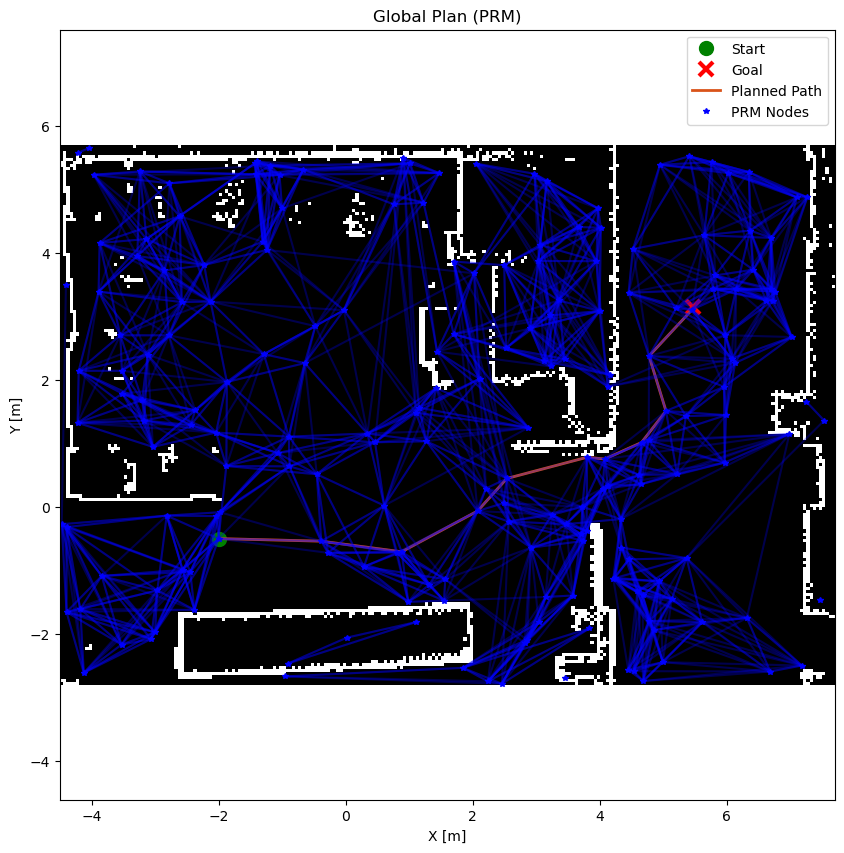

In [9]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import heapq

# =============================================================================
# 5) GLOBAL PLANNER IMPLEMENTATIONS (RRT and PRM)
#
# This block contains the Python implementation of RRT and PRM planners,
# equivalent to MATLAB's plannerRRT and plannerPRM.
# =============================================================================

# ------------------------------------------------------------------------------
# Helper Functions and Classes
# ------------------------------------------------------------------------------

class Node:
    """
    Node class for RRT/PRM planners. This is a helper to store graph information.
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.path_x = []
        self.path_y = []
        self.parent = None
        self.cost = 0.0

def world_to_map(world_coords, origin, res):
    """ Converts world coordinates (meters) to map coordinates (pixels). """
    mx = int((world_coords[0] - origin[0]) / res)
    my = int((world_coords[1] - origin[1]) / res)
    return [mx, my]

def map_to_world(map_coords, origin, res):
    """ Converts map coordinates (pixels) to world coordinates (meters). """
    wx = map_coords[0] * res + origin[0]
    wy = map_coords[1] * res + origin[1]
    return [wx, wy]

# ------------------------------------------------------------------------------
# RRT Planner (Equivalent to plannerRRT)
# ------------------------------------------------------------------------------
class RRT:
    """
    RRT Planner Class.
    Corresponds to:
    - planner = plannerRRT(stateSpace, stateValidator)
    - planner.MaxIterations = ...
    - planner.MaxConnectionDistance = ...
    """
    def __init__(self, obstacle_map, start, goal, expand_dis=15.0, 
                 path_resolution=1.0, goal_sample_rate=10, max_iter=500):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.obstacle_map = obstacle_map
        self.map_height, self.map_width = obstacle_map.shape
        
        # Corresponds to planner.MaxConnectionDistance
        self.expand_dis = expand_dis 
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        # Corresponds to planner.MaxIterations
        self.max_iter = max_iter 
        self.node_list = []
        
    def plan(self):
        """
        Main planning function.
        Corresponds to: [path, solnInfo] = plan(planner, start_pose, goal_pose)
        """
        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            # The stateValidator is implicitly used here by checking for collisions
            if self.check_collision(new_node):
                self.node_list.append(new_node)

            # Check if goal is reachable
            if self.calc_dist_to_goal(self.node_list[-1].x, self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end, self.expand_dis)
                if self.check_collision(final_node):
                    path, tree = self.generate_final_path(len(self.node_list) - 1)
                    return path, tree, True

        return None, self.get_tree_for_plotting(), False # Path not found

    def steer(self, from_node, to_node, extend_length=float("inf")):
        new_node = Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(int(n_expand)):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node
        return new_node

    def generate_final_path(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])
        path.reverse()
        return path, self.get_tree_for_plotting()
        
    def get_tree_for_plotting(self):
        tree = []
        for node in self.node_list:
            if node.parent:
                tree.append(([node.x, node.parent.x], [node.y, node.parent.y]))
        return tree

    def check_collision(self, node):
        """
        Collision check. Equivalent to stateValidator.isStateValid
        """
        if node is None:
            return False
            
        for x, y in zip(node.path_x, node.path_y):
            if not (0 <= x < self.map_width and 0 <= y < self.map_height):
                 return False # out of bounds
            if self.obstacle_map[int(y), int(x)]:
                return False  # collision
        return True
    
    # --- Helper methods ---
    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = Node(random.uniform(0, self.map_width),
                       random.uniform(0, self.map_height))
        else:  # goal point sampling
            rnd = Node(self.end.x, self.end.y)
        return rnd

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))
        return minind

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta

# ------------------------------------------------------------------------------
# PRM Planner (Equivalent to plannerPRM)
# ------------------------------------------------------------------------------
def prm_planning(start, goal, obstacle_map, n_samples=200, robot_radius=8.0):
    """
    PRM Planner Function.
    """
    height, width = obstacle_map.shape

    def check_prm_collision(start_node, end_node):
        """Robust collision checker. Samples the line at a 1-pixel resolution."""
        px, py = end_node.x - start_node.x, end_node.y - start_node.y
        edge_len = math.hypot(px, py)
        if edge_len < 1e-6: return False 
        
        n_step = int(edge_len) + 1
        for i in range(n_step + 1):
            x, y = start_node.x + i * (px / n_step), start_node.y + i * (py / n_step)
            if not (0 <= x < width and 0 <= y < height): return True
            if obstacle_map[int(y), int(x)]: return True
        return False

    sample_x, sample_y = [], []
    while len(sample_x) < n_samples:
        tx, ty = (random.random() * width), (random.random() * height)
        if not obstacle_map[int(ty),int(tx)]:
            sample_x.append(tx)
            sample_y.append(ty)

    sample_x.extend([start[0], goal[0]])
    sample_y.extend([start[1], goal[1]])
    
    node_list = [Node(x, y) for x, y in zip(sample_x, sample_y)]
    roadmap, n_nodes = [], len(node_list)
    node_tree = cKDTree(np.vstack((sample_x, sample_y)).T)

    for (i, node) in enumerate(node_list):
        _, inds = node_tree.query([node.x, node.y], k=n_nodes)
        edges = [inds[ii] for ii in range(1, len(inds)) if not check_prm_collision(node, node_list[inds[ii]])]
        roadmap.append(edges[:10]) # Connect to up to 10 neighbors

    path_nodes_idx, _ = dijkstra_planning(
        start_idx=n_nodes - 2, goal_idx=n_nodes - 1,
        node_list=node_list, roadmap=roadmap
    )

    if path_nodes_idx is None:
        return None, node_list, roadmap, False
        
    path = [[node_list[i].x, node_list[i].y] for i in path_nodes_idx]
    return path, node_list, roadmap, True

def dijkstra_planning(start_idx, goal_idx, node_list, roadmap):
    """Dijkstra's algorithm for finding the shortest path in the roadmap."""
    open_set, closed_set, came_from = [(0.0, start_idx)], set(), {}
    g_score = {i: float('inf') for i in range(len(node_list))}
    g_score[start_idx] = 0

    while open_set:
        _, current_idx = heapq.heappop(open_set)
        if current_idx == goal_idx:
            path = [current_idx]
            while current_idx in came_from:
                current_idx = came_from[current_idx]
                path.append(current_idx)
            return path[::-1], g_score[goal_idx]

        if current_idx in closed_set: continue
        closed_set.add(current_idx)

        current_node = node_list[current_idx]
        for neighbor_idx in roadmap[current_idx]:
            d = math.hypot(current_node.x - node_list[neighbor_idx].x, current_node.y - node_list[neighbor_idx].y)
            tentative_g_score = g_score[current_idx] + d
            if tentative_g_score < g_score[neighbor_idx]:
                came_from[neighbor_idx], g_score[neighbor_idx] = current_idx, tentative_g_score
                heapq.heappush(open_set, (g_score[neighbor_idx], neighbor_idx))
    return None, float('inf')

# =============================================================================
# Main Planning and Visualization Logic
# =============================================================================

# --- Configuration ---
# Choose between "RRT" and "PRM"
global_planner = "PRM" 

# --- Prepare Start and Goal Poses ---
start_world = [robot_x, robot_y]
goal_world = [goalPose.pose.position.x, goalPose.pose.position.y]
map_origin = [x_origin, y_origin]
start_map = world_to_map(start_world, map_origin, res)
goal_map = world_to_map(goal_world, map_origin, res)

# --- Execute Planner ---
plannedPath_map_coords, is_path_found = None, False
prm_nodes, prm_roadmap, rrt_tree = None, None, None

if global_planner == "RRT":
    print("Executing RRT...")
    rrt = RRT(obstacle_map=bwimage, start=start_map, goal=goal_map,
              max_iter=1000, expand_dis=20.0)
    plannedPath_map_coords, rrt_tree, is_path_found = rrt.plan()
elif global_planner == "PRM":
    print("Executing PRM...")
    plannedPath_map_coords, prm_nodes, prm_roadmap, is_path_found = prm_planning(
        start=start_map, goal=goal_map, obstacle_map=bwimage,
        n_samples=200, robot_radius=8
    )
else:
    raise ValueError(f"Unknown global planner: {global_planner}")

# --- Convert Path to World Coordinates and Visualize ---
plannedPath_world_coords = []
if is_path_found:
    print("Path found!")
    for point in plannedPath_map_coords:
        plannedPath_world_coords.append(map_to_world(point, map_origin, res))
else:
    print(f"Warning: {global_planner}: Path not found.")

# Visualize the plan
plt.figure(figsize=(10,10))
plt.imshow(bwimage, cmap='gray', origin='lower', extent=extent)
plt.plot(start_world[0], start_world[1], 'go', markersize=10, label='Start')
plt.plot(goal_world[0], goal_world[1], 'rx', markersize=10, mew=3, label='Goal')

if is_path_found:
    path_x, path_y = zip(*plannedPath_world_coords)
    plt.plot(path_x, path_y, '-', color=[0.85, 0.325, 0.098], linewidth=2, label='Planned Path')
    
    if global_planner == "RRT" and rrt_tree:
        for (x_coords, y_coords) in rrt_tree:
            wx1, wy1 = map_to_world([x_coords[0], y_coords[0]], map_origin, res)
            wx2, wy2 = map_to_world([x_coords[1], y_coords[1]], map_origin, res)
            plt.plot([wx1, wx2], [wy1, wy2], '.-', color='lightblue')
    elif global_planner == "PRM" and prm_nodes:
        node_x = [map_to_world([n.x, 0], map_origin, res)[0] for n in prm_nodes]
        node_y = [map_to_world([0, n.y], map_origin, res)[1] for n in prm_nodes]
        plt.plot(node_x, node_y, 'b*', markersize=4, label='PRM Nodes')
        for i, edges in enumerate(prm_roadmap):
            for edge_idx in edges:
                node1_w = map_to_world([prm_nodes[i].x, prm_nodes[i].y], map_origin, res)
                node2_w = map_to_world([prm_nodes[edge_idx].x, prm_nodes[edge_idx].y], map_origin, res)
                plt.plot([node1_w[0], node2_w[0]], [node1_w[1], node2_w[1]], 'b-', alpha=0.3)

plt.title(f'Global Plan ({global_planner})')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.legend()
plt.axis('equal')
plt.show()

B-Spline smoothing successful and collision-free.


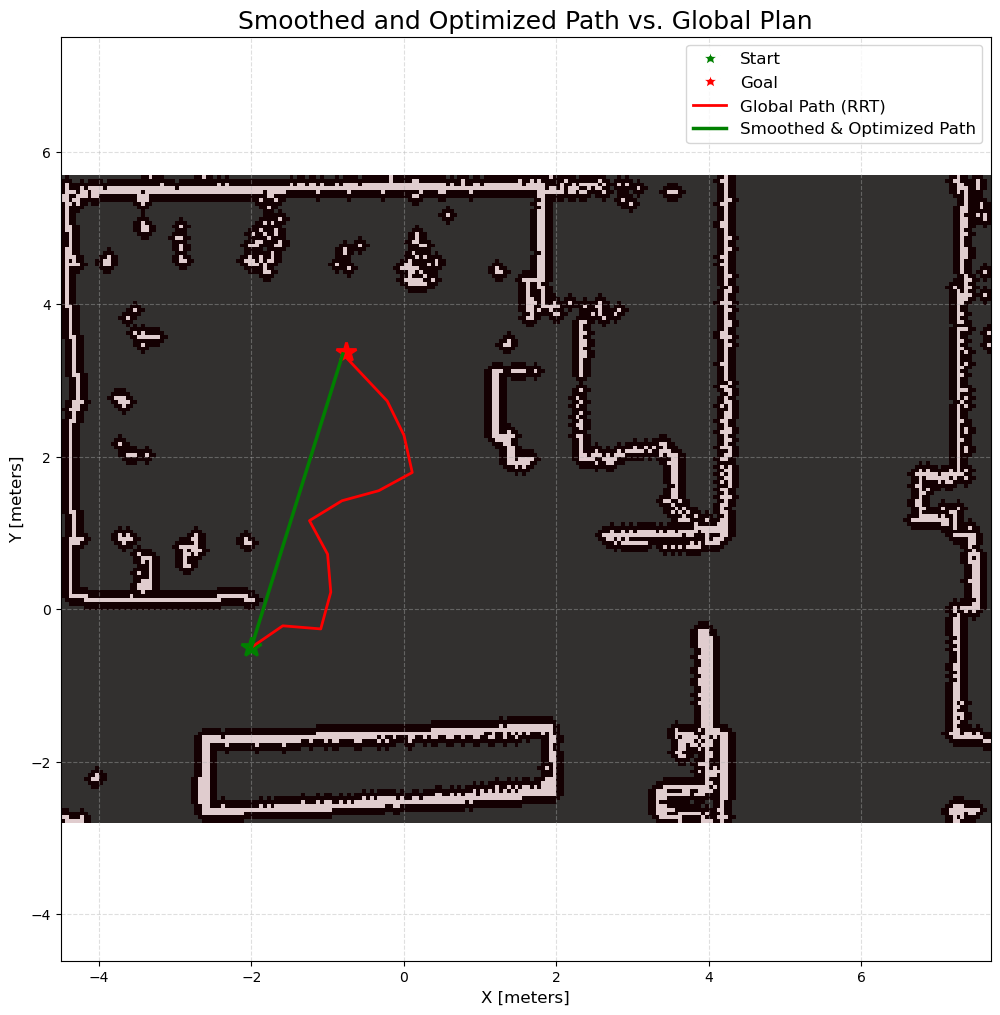

In [26]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from scipy.interpolate import interp1d, splprep, splev
from matplotlib.lines import Line2D


# ==============================================================================
# PART 1: PATH OPTIMIZATION & SMOOTHING IMPLEMENTATIONS
# ==============================================================================

# --- Configuration for Path Optimization ---
optimize_options = {
    'ObstacleSafetyMargin': 0.1,
    'MaxPathStates': 200,
    'ShortcutIterations': 1500,
}

# --- Helper Functions for Optimization and Smoothing ---

def world_to_map(world_coords, origin, res):
    """Converts world coordinates (meters) to map coordinates (pixels)."""
    map_x = (world_coords[0] - origin[0]) / res
    map_y = (world_coords[1] - origin[1]) / res
    return (map_x, map_y)

def is_segment_collision_free(p1_world, p2_world, inflated_map, origin, res):
    """Checks if a straight line segment is collision-free on the inflated map."""
    p1_map = world_to_map(p1_world, origin, res)
    p2_map = world_to_map(p2_world, origin, res)

    num_steps = int(math.hypot(p2_map[0] - p1_map[0], p2_map[1] - p1_map[1])) + 1
    x_line = np.linspace(p1_map[0], p2_map[0], num_steps).astype(int)
    y_line = np.linspace(p1_map[1], p2_map[1], num_steps).astype(int)

    map_h, map_w = inflated_map.shape
    for x, y in zip(x_line, y_line):
        if not (0 <= y < map_h and 0 <= x < map_w) or inflated_map[y, x]:
            return False
    return True

def is_path_collision_free(path_world, inflated_map, origin, res):
    """Checks if an entire path (list of points) is collision-free."""
    for point_world in path_world:
        point_map = world_to_map(point_world, origin, res)
        # Cast to int for array indexing
        y, x = int(point_map[1]), int(point_map[0])
        map_h, map_w = inflated_map.shape
        if not (0 <= y < map_h and 0 <= x < map_w) or inflated_map[y, x]:
            return False
    return True

def resample_path_uniformly(path, num_points):
    """
    Resamples a path to have a specific number of uniformly spaced points.
    Uses linear interpolation.
    """
    path = np.array(path)
    # Handle paths with less than 2 points
    if len(path) < 2:
        return path

    # Calculate the cumulative distance along the path segments
    distances = np.cumsum(np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1)))
    # Prepend 0 for the start of the path
    distances = np.insert(distances, 0, 0)

    # If the path has no length (all points are the same), return n copies of the first point
    if distances[-1] == 0:
        return np.array([path[0]] * num_points)

    # Create new, uniformly spaced distances
    new_distances = np.linspace(0, distances[-1], num_points)

    # Create interpolation functions for x and y coordinates
    # The 'distances' are the "x" values for the interpolation, and path coordinates are "y"
    fx = interp1d(distances, path[:, 0])
    fy = interp1d(distances, path[:, 1])

    # Interpolate the new points
    new_x = fx(new_distances)
    new_y = fy(new_distances)

    return np.vstack((new_x, new_y)).T

def optimize_path_shortcut(path, inflated_map, origin, res, options):
    """Optimizes a path using only random shortcutting."""
    optimized_path = list(path)
    for _ in range(options['ShortcutIterations']):
        if len(optimized_path) < 3:
            break
        idx1, idx2 = sorted(random.sample(range(len(optimized_path)), 2))
        if idx2 > idx1 + 1:
            if is_segment_collision_free(optimized_path[idx1], optimized_path[idx2], inflated_map, origin, res):
                optimized_path = optimized_path[:idx1+1] + optimized_path[idx2:]
    return optimized_path

def smooth_path_bspline(path, num_points=200, smoothing_factor=0.1):
    """
    Smooths a path using B-Spline interpolation.
    - smoothing_factor (s): A crucial parameter.
      s=0: The spline will pass through all waypoints (interpolation).
      s>0: The spline is smoother but may deviate from waypoints (approximation).
    """
    if len(path) < 4: # B-spline needs at least k+1 points (k=3 for cubic)
        # Fallback to simple resampling for very short paths
        return resample_path_uniformly(path, num_points)

    path_np = np.array(path)
    x = path_np[:, 0]
    y = path_np[:, 1]

    # splprep finds the B-spline representation of a 2D curve
    tck, u = splprep([x, y], s=smoothing_factor, k=3)

    # splev evaluates the B-spline at new, uniformly spaced points
    u_new = np.linspace(u.min(), u.max(), num_points)
    x_smooth, y_smooth = splev(u_new, tck)

    return np.vstack((x_smooth, y_smooth)).T

# =============================================================================
# PART 2: MAIN EXECUTION AND VISUALIZATION
# =============================================================================

smoothed_path_world_coords = None

if is_path_found:
    # 1. Inflate the obstacle map for safety margin
    margin_pixels = math.ceil(optimize_options['ObstacleSafetyMargin'] / res)
    y, x = np.ogrid[-margin_pixels:margin_pixels+1, -margin_pixels:margin_pixels+1]
    disk_structure = x**2 + y**2 <= margin_pixels**2
    inflated_bwimage = binary_dilation(bwimage, structure=disk_structure)

    # 2. Optimize the path using shortcutting
    shortcutted_path = optimize_path_shortcut(
        plannedPath_world_coords, inflated_bwimage, map_origin, res, optimize_options
    )

    # 3. Smooth the shortcutted path using B-Splines
    # We generate more points than MaxPathStates initially for better collision checking
    smoothed_path_candidate = smooth_path_bspline(
        shortcutted_path,
        num_points=optimize_options['MaxPathStates'] * 10, # Higher density for checking
        smoothing_factor=0.01 # Tune this value for more/less smoothing
    )

    # 4. Check if the new smoothed path is still collision-free
    if is_path_collision_free(smoothed_path_candidate, inflated_bwimage, map_origin, res):
        print("B-Spline smoothing successful and collision-free.")
        # If safe, resample it to the final desired number of states
        smoothed_path_world_coords = resample_path_uniformly(
            smoothed_path_candidate, optimize_options['MaxPathStates']
        )
    else:
        print("Warning: B-Spline path collided with safety margin. Falling back to shortcutted path.")
        # Fallback: Resample the (less smooth) shortcutted path if smoothing failed
        smoothed_path_world_coords = resample_path_uniformly(
            shortcutted_path, optimize_options['MaxPathStates']
        )

# --- Visualization ---
plt.figure(figsize=(12, 12))
ax = plt.gca()

ax.imshow(bwimage, cmap='gray', origin='lower', extent=extent)
ax.imshow(inflated_bwimage, cmap='Reds', origin='lower', extent=extent, alpha=0.2)
ax.plot(start_world[0], start_world[1], '*g', markersize=15, mew=2)
ax.plot(goal_world[0], goal_world[1], '*r', markersize=15, mew=2)
path_x, path_y = zip(*plannedPath_world_coords)
ax.plot(path_x, path_y, 'r-', linewidth=2)

# Plot the final smoothed path
if smoothed_path_world_coords is not None:
    opt_path_x, opt_path_y = zip(*smoothed_path_world_coords)
    ax.plot(opt_path_x, opt_path_y, 'g-', linewidth=2.5)

# Create a clean legend
legend_elements = [
    Line2D([0], [0], marker='*', color='w', label='Start', markerfacecolor='g', markersize=15, mew=2),
    Line2D([0], [0], marker='*', color='w', label='Goal', markerfacecolor='r', markersize=15, mew=2),
    Line2D([0], [0], color='r', lw=2, label='Global Path (RRT)'),
    Line2D([0], [0], color='g', lw=2.5, label='Smoothed & Optimized Path')
]
ax.legend(handles=legend_elements, fontsize=12)

ax.set_title('Smoothed and Optimized Path vs. Global Plan', fontsize=18)
ax.set_xlabel("X [meters]", fontsize=12)
ax.set_ylabel("Y [meters]", fontsize=12)
ax.axis('equal')
ax.grid(True, linestyle='--', alpha=0.4)
plt.show()

Sending stop command and shutting down executor...
Navigation loop finished.


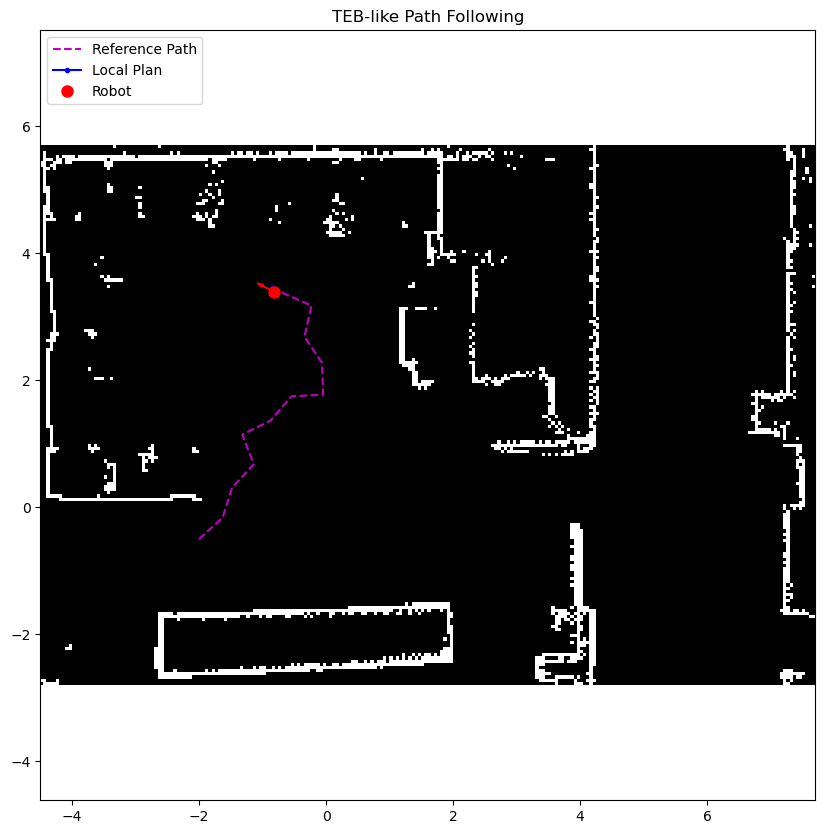

In [10]:
import time
import threading
from rclpy.executors import SingleThreadedExecutor
from IPython.display import display, clear_output

# =============================================================================
# PART 4: LOCAL CONTROLLER (TEB-LIKE) IMPLEMENTATION
#
# NOTE: This cell now uses a background thread for rclpy.spin() to ensure
# the odometry data is always up-to-date, preventing overshooting.
# =============================================================================

class SimpleTEBController:
    """
    A simplified, TEB-like controller using the Pure Pursuit algorithm.
    """
    def __init__(self, ref_path, max_velocity, look_ahead_time, goal_tolerance=0.1):
        self.ref_path = np.array(ref_path)
        self.max_linear_vel = max_velocity[0]
        self.max_angular_vel = max_velocity[1]
        self.look_ahead_time = look_ahead_time
        self.goal_tolerance = goal_tolerance
        
        # Pure Pursuit parameters
        self.k_lookahead = 0.5  # Proportional gain for lookahead distance
        self.min_lookahead_dist = 0.3 # Minimum lookahead distance
        self.last_target_idx = 0

    def __call__(self, current_pose, current_velocity):
        """
        Calculates the velocity commands to follow the path.
        Corresponds to: [vel, tstamps, path, info] = teb(pose, vel)
        """
        pose_x, pose_y, pose_theta = current_pose
        v_linear_current = current_velocity[0]

        # --- 1. Find the target point on the path (Pure Pursuit) ---
        lookahead_dist = self.k_lookahead * v_linear_current + self.min_lookahead_dist
        
        dx = self.ref_path[:, 0] - pose_x
        dy = self.ref_path[:, 1] - pose_y
        distances = np.hypot(dx, dy)
        closest_idx = np.argmin(distances)
        
        target_idx = closest_idx
        while target_idx < len(self.ref_path) - 1:
            if distances[target_idx] > lookahead_dist:
                break
            target_idx += 1
        
        self.last_target_idx = target_idx
        target_point = self.ref_path[target_idx]

        # --- 2. Check if goal is reached ---
        dist_to_goal = math.hypot(pose_x - self.ref_path[-1, 0], pose_y - self.ref_path[-1, 1])
        info = {'HasReachedGoal': False}
        if dist_to_goal < self.goal_tolerance:
            info['HasReachedGoal'] = True
            vel_cmds = [[0.0, 0.0]]
            local_plan_for_viz = [[pose_x, pose_y], list(self.ref_path[-1])]
            return vel_cmds, [], local_plan_for_viz, info

        # --- 3. Calculate velocity commands ---
        alpha_world = math.atan2(target_point[1] - pose_y, target_point[0] - pose_x)
        alpha_robot = math.atan2(math.sin(alpha_world - pose_theta), math.cos(alpha_world - pose_theta))
        
        linear_vel = self.max_linear_vel
        angular_vel = (2.0 * linear_vel * math.sin(alpha_robot)) / lookahead_dist
        
        linear_vel = np.clip(linear_vel, -self.max_linear_vel, self.max_linear_vel)
        angular_vel = np.clip(angular_vel, -self.max_angular_vel, self.max_angular_vel)
        
        vel_cmds = [[linear_vel, angular_vel]]
        local_plan_for_viz = [[pose_x, pose_y], list(target_point)]
        
        return vel_cmds, [], local_plan_for_viz, info

# =============================================================================
# MAIN CONTROLLER LOOP (Multi-threaded version)
# =============================================================================

if not is_path_found:
    print("Skipping controller loop because no valid path was found.")
else:
    # --- Controller Initialization ---
    teb = SimpleTEBController(
        ref_path=plannedPath_world_coords,
        max_velocity=[0.22, 1.5], # [v_max, w_max], reduced linear for safety
        look_ahead_time=5.0,
        goal_tolerance=0.1
    )

    rate_hz = 10
    goalReached = False
    
    # --- Set up ROS2 Executor in a background thread ---
    # This allows callbacks (like odom) to be processed continuously
    # without blocking the main control loop.
    executor = SingleThreadedExecutor()
    executor.add_node(Python_node)
    
    # Run the executor in a separate thread
    executor_thread = threading.Thread(target=executor.spin, daemon=True)
    executor_thread.start()
    
    # --- Visualization Setup ---
    fig, ax = plt.subplots(figsize=(10, 10))
    display(fig)

    print('Starting TEB-like controller for path following...')

    try:
        while not goalReached and rclpy.ok():
            # The global `current_pose` and `latest_odom_msg` are now being
            # updated constantly in the background by the executor thread.
            if current_pose is None or latest_odom_msg is None:
                print("Waiting for initial odometry...")
                time.sleep(0.5)
                continue
            
            # Get current velocity
            cur_vel_x = latest_odom_msg.twist.twist.linear.x
            
            # Get next velocity commands from the controller
            vel_cmds, _, local_path_viz, info = teb(current_pose, [cur_vel_x, 0.0])
            
            goalReached = info.get('HasReachedGoal', False)
            if goalReached:
                print('Goal reached according to controller.')
                vel_cmds = [[0.0, 0.0]]

            # --- Visualization ---
            ax.clear()
            ax.imshow(bwimage, cmap='gray', origin='lower', extent=extent)
            ref_path_np = np.array(plannedPath_world_coords)
            ax.plot(ref_path_np[:, 0], ref_path_np[:, 1], 'm--', linewidth=1.5, label='Reference Path')
            
            if local_path_viz:
                lp_np = np.array(local_path_viz)
                ax.plot(lp_np[:, 0], lp_np[:, 1], 'b.-', linewidth=1.5, label='Local Plan')
            
            cur_x, cur_y, cur_theta = current_pose
            ax.plot(cur_x, cur_y, 'ro', markersize=8, markerfacecolor='r', label='Robot')
            ax.arrow(cur_x, cur_y, 0.2*math.cos(cur_theta), 0.2*math.sin(cur_theta), 
                     head_width=0.05, head_length=0.1, fc='r', ec='r')

            ax.set_title('TEB-like Path Following')
            ax.legend(loc='upper left')
            ax.axis('equal')
            display(fig)
            clear_output(wait=True)

            # Publish cmd_vel
            vel_msg = Twist()
            vel_msg.linear.x = float(vel_cmds[0][0])
            vel_msg.angular.z = float(vel_cmds[0][1])
            velPub.publish(vel_msg)

            time.sleep(1/rate_hz)

    except KeyboardInterrupt:
        print("Loop interrupted by user.")
    finally:
        # Cleanly shut down
        print("Sending stop command and shutting down executor...")
        stop_msg = Twist()
        velPub.publish(stop_msg)
        executor.shutdown()
        # Note: The main node destroy and rclpy shutdown is in the next cell
        print('Navigation loop finished.')

In [28]:
Python_node.destroy_node()
rclpy.shutdown()
print("ROS 2 node destroyed and rclpy shut down.")

ROS 2 node destroyed and rclpy shut down.
